In [1]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import keras
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from urllib.request import urlretrieve
import zipfile
import matplotlib.pyplot as plt
from image_funcs import get_image,load_imgs,plot_imgs


Using TensorFlow backend.


In [ ]:
#Retrieve celebrity images
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
urlretrieve(url,'celeba')

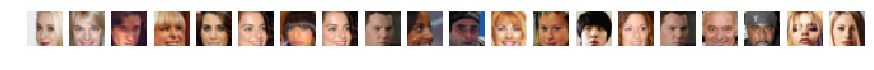

In [14]:
#show example
imgs=load_imgs(1000)
fig, axs = plt.subplots(1,20,figsize=(15, 15))  
rand10=list(np.random.randint(0,100,20))
cnt=0
for i in rand10:
    axs[cnt].imshow(imgs[i])
    axs[cnt].axis('off')
    cnt+=1
plt.show()

Build generator and discriminator functions

In [18]:
img_rows = 28
img_cols = 28
channels = 3
img_shape = (img_rows, img_cols, channels)
latent_dim = 100


def build_generator():
    
    with tf.device('/gpu:0'):
        model = Sequential()

        model.add(Dense(512 * 7 * 7, activation="relu", input_dim=latent_dim))
        model.add(Reshape((7, 7, 512)))
        model.add(Conv2DTranspose(256, kernel_size=5,strides=2, padding="same"))
        model.add(BatchNormalization(momentum=.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, kernel_size=5,strides=2, padding="same"))
        model.add(BatchNormalization(momentum=.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(3, kernel_size=5,strides=1, padding="same"))
        model.add(BatchNormalization(momentum=.8))
        model.add(Activation("tanh"))
        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)
    #modelout=keras.utils.multi_gpu_model(Model(noise, img),gpus=8)
    return Model(noise, img)

def build_discriminator():
    
    with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Conv2D(512, kernel_size=5, strides=2, padding="same",input_shape=img_shape))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=img_shape)
        validity = model(img)
    #modelout=keras.utils.multi_gpu_model(Model(img, validity),gpus=8)
    return Model(img, validity)




In [19]:
keras.backend.clear_session()
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
optimizer=Adam(0.0002, 0.5),
metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 512)       38912     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 512)       2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 512)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 256)         0         
__________

Train model

In [ ]:
def train( epochs,data, batch_size=128, sample_interval=100):

    # Rescale -1 to 1
    X_train =  data/ 127.5 - 1.
    

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))*.8#soft labeling seems to improve image generation
    fake = np.zeros((batch_size, 1))+.1

    for epoch in range(epochs):
        if epoch % 10==0:
            print(epoch,end='-')

    # ---------------------
    #  Train Discriminator
    # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx,:,:,:]

        noise = np.random.uniform(-1, 1, (batch_size, latent_dim))#z latent vector/uniform works best here

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)#additional 'fake' pass improves generator
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)
        

        # Plot the progress
        if epoch % sample_interval == 0:
            
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            plot_imgs(2)

  
train(epochs=20000,data=np.array(imgs))

In [ ]:
#save models
generator.save('generator')
discriminator.save('discriminator')
combined.save('combined')

Find similar images

In [21]:
#load trained generator and images
generator=keras.models.load_model('generator')
no_images=10000
imgs=load_imgs(no_images)

/usr/local/lib64/python3.4/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


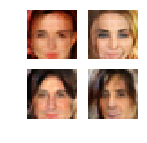

In [24]:
#sample images and plot them
imgsex=plot_imgs(generator,2)

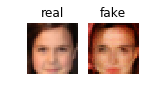

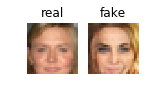

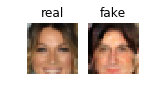

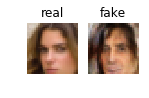

In [25]:
#find similar real and fake images
for i in range(imgsex.shape[0]):
    y=np.reshape(np.array(imgs)/255,(no_images,28*28*3))
    x=np.reshape(np.array(imgsex[i]),(1,28*28*3)) 

    diff2=np.square(x-y).mean(1)
    imgmatch=imgs[np.argmin(diff2)]

    fig, axs = plt.subplots(1, 2,figsize=(2,2))
    imlst=[imgmatch,imgsex[i]]
    for i in range(2):
        axs[i].imshow(imlst[i])
        axs[i].axis('off')
        axs[i].set_title(['real','fake'][i])

    plt.show()